In [1]:
from get_data import *

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.2.4-tf
2.0.0


# Inspect Data Quality

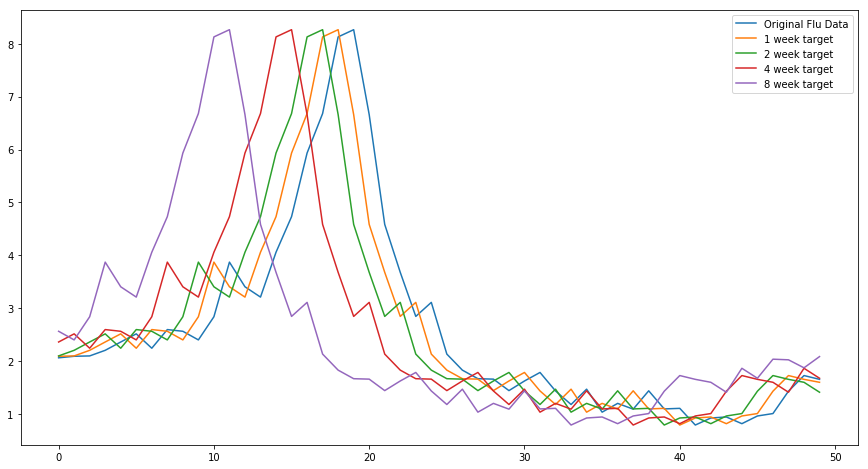

In [2]:
state = 'Texas'

orig = train_dfs[state]['texas_flu']
target_1 = train_dfs[state]['target_1']
target_2 = train_dfs[state]['target_2']
target_4 = train_dfs[state]['target_4']
target_8 = train_dfs[state]['target_8']

print_len = 50
plt.figure(figsize=(15,8))
plt.plot(orig[:print_len], label = "Original Flu Data")
plt.plot(target_1[:print_len], label = '1 week target')
plt.plot(target_2[:print_len], label = '2 week target')
plt.plot(target_4[:print_len], label = '4 week target')
plt.plot(target_8[:print_len], label = '8 week target')
plt.legend()

# Test Data Getter

In [3]:
# Get TS data
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 1) (85, 1) (453, 1)
(368, 1) (85, 1) (453, 1)


In [4]:
# Get TS with lag data
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'lag_8'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 2) (85, 2) (453, 2)
(368, 1) (85, 1) (453, 1)


In [5]:
# Get TS + GT
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'GT'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 97) (85, 97) (453, 97)
(368, 1) (85, 1) (453, 1)


In [6]:
# Get TS + other state
X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS', 'other_states'], 1, None)
print(X_train.shape, X_test.shape, X_all.shape)
print(y_train.shape, y_test.shape, y_all.shape)

(368, 50) (85, 50) (453, 50)
(368, 1) (85, 1) (453, 1)


# Try out Time Series Models

### Persistence

In [7]:
def persistence(target_state, target_lag, if_plot=True,verbose=1):
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(state, ['TS'], target_lag, None)
    
    # model and predict
    y_pred = inverse_transform_preds(y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the persistence model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

RMSE for the persistence model of Texas is 1.023945


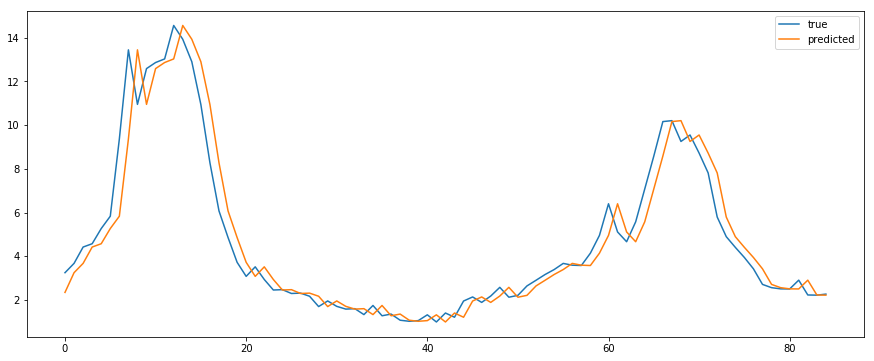

RMSE for the persistence model of New York is 1.023945


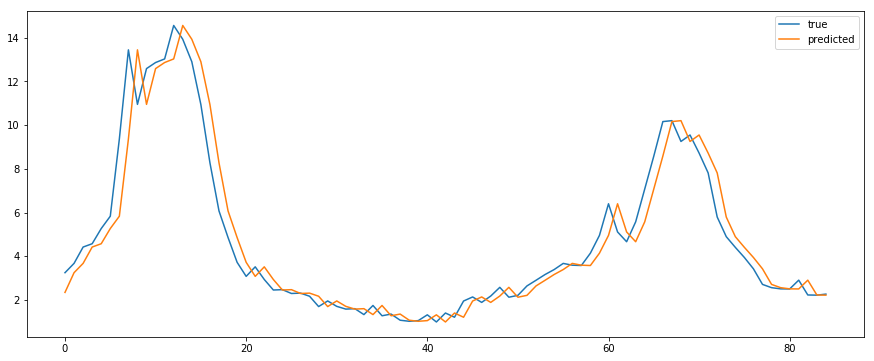

1.0239446172112445

In [8]:
persistence('Texas', 1, True)
persistence('New York', 1, True)

# AR

In [9]:
def AutoReg_Walk_Forward(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            # If retrain, retrain at every refit_period steps
            if t % refit_period == 0: 
                AR = LinearRegression().fit(X_train_temp, y_train_temp)
        else:
            # If not retrain, only train at the first period
            if t == 0: 
                AR = LinearRegression().fit(X_train_temp, y_train_temp)
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the AutoReg Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

RMSE for the AutoReg Model of Texas is 0.976578


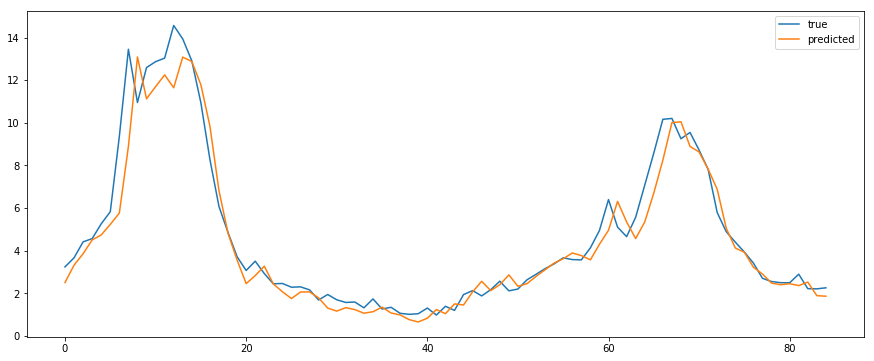

RMSE for the AutoReg Model of New York is 0.641405


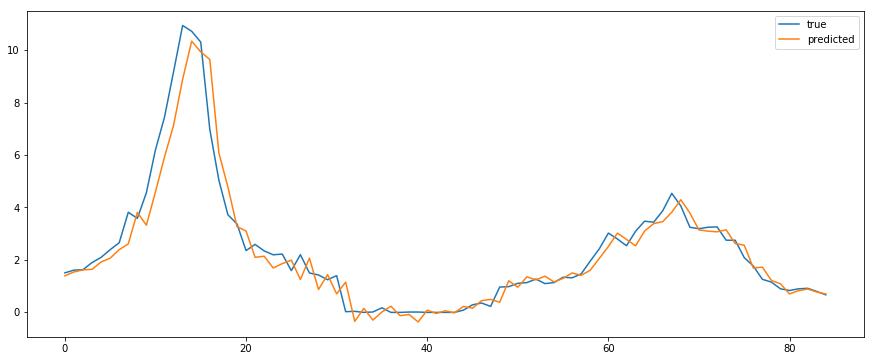

0.641405331969808

In [10]:
# AR WO retrain
AutoReg_Walk_Forward('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)
AutoReg_Walk_Forward('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)

RMSE for the AutoReg Model of Texas is 0.979252


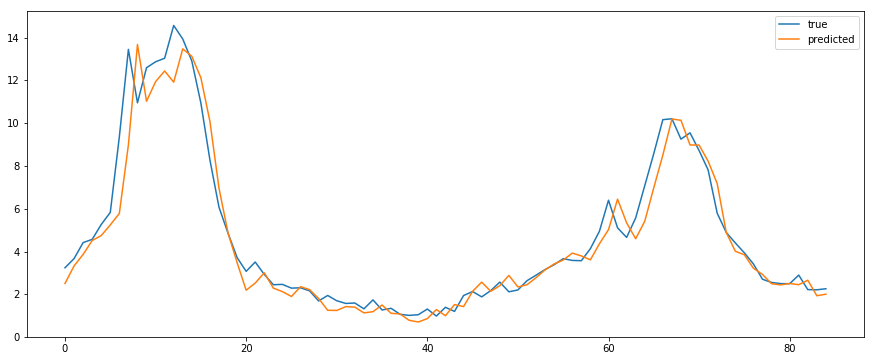

RMSE for the AutoReg Model of New York is 0.636332


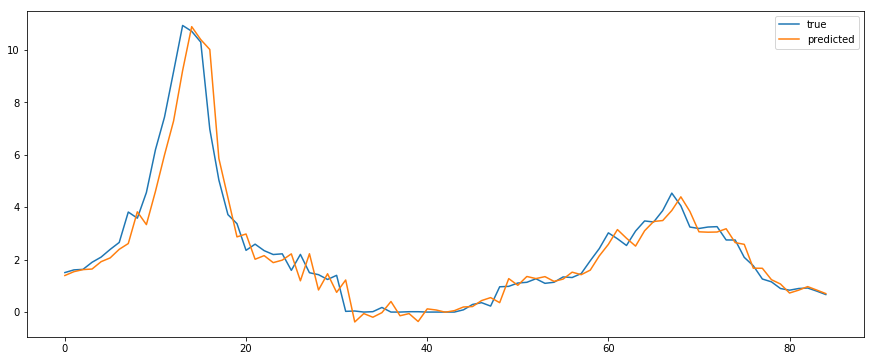

0.6363320574319551

In [11]:
# AR with retrain
AutoReg_Walk_Forward('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)
AutoReg_Walk_Forward('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)

## ARGO

In [12]:
def ARGO(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS','GT']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            if t % refit_period == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
        else:
            if t == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the ARGO Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

RMSE for the ARGO Model of Texas is 0.794215


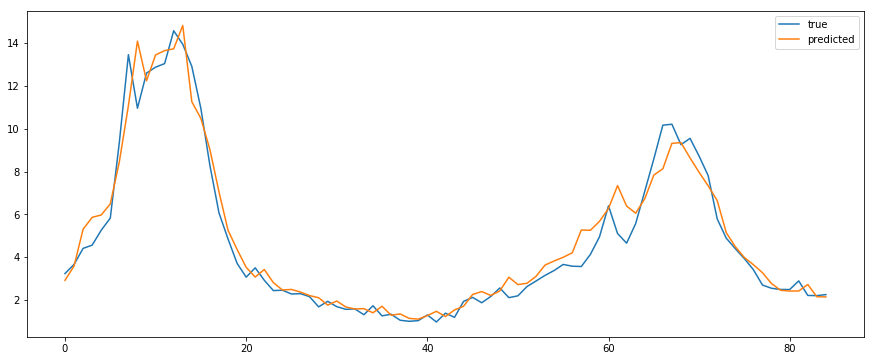

RMSE for the ARGO Model of New York is 0.938074


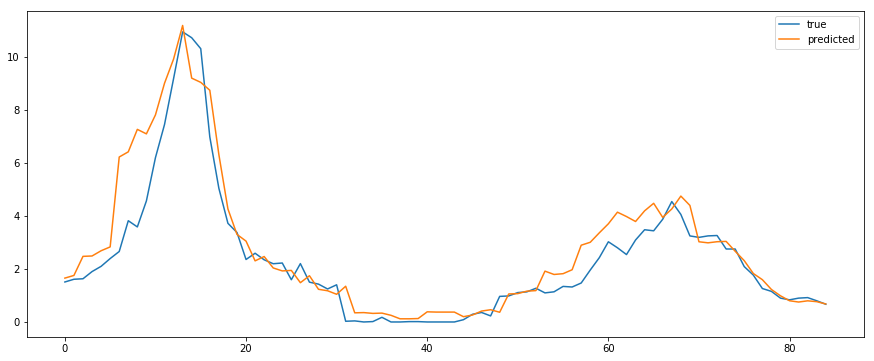

0.9380739935475506

In [13]:
# ARGO no refit
ARGO('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)
ARGO('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)

RMSE for the ARGO Model of Texas is 0.865451


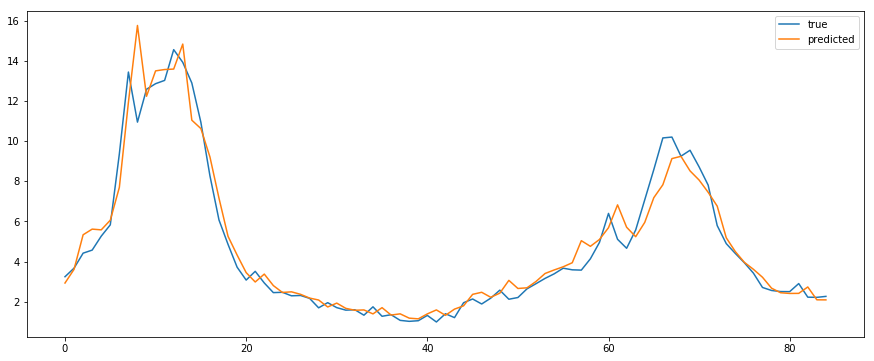

RMSE for the ARGO Model of New York is 0.716509


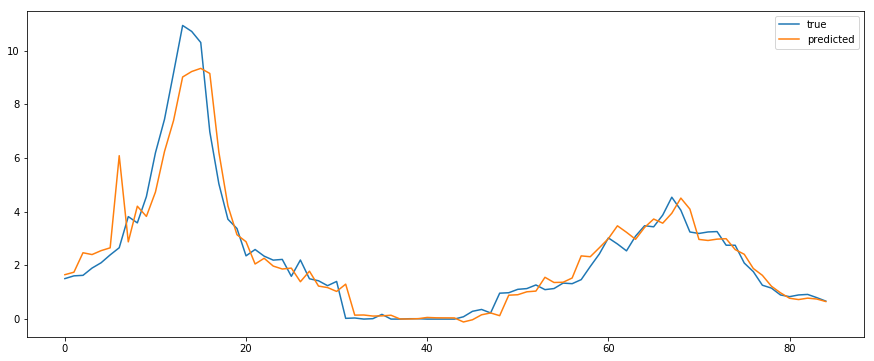

0.7165086858405523

In [14]:
# ARGO with refit
ARGO('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)
ARGO('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=True, refit_period = 12)

## LNAR

In [15]:
def LNAR(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1, with_gt = False, verbose=1):
    lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
    if with_gt: lag_cols += ['GT']
    X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS','other_states']+lag_cols, target_lag)    
    
    train_len = len(X_train)
    test_len = len(X_all) - train_len 
    y_pred = np.zeros((test_len))
    
    
    for t in range(test_len):
        X_train_temp = X_all[:train_len+t]
        y_train_temp = y_all[:train_len+t]
        X_test_temp = X_all[train_len+t:]
        
        if if_refit:
            if t % refit_period == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
        else:
            if t == 0: 
                AR = LassoCV(alphas=[1e-4,1e-3,1e-2,1e-1,1,2], max_iter=1e6, cv=5, random_state=109).fit(X_train_temp, y_train_temp.flatten())
            
        preds = AR.predict(X_test_temp)
        y_pred[t] = preds[0]
        
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose: print(f"RMSE for the LNAR Model of {target_state} is {rmse:.6f}")
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(y_pred, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

In [16]:
# LNAR no refit no GT
LNAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=False, refit_period = 1, with_gt=False)
LNAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=False, refit_period = 1, with_gt=False)

RMSE for the LNAR Model of Texas is 0.998898
RMSE for the LNAR Model of New York is 0.627460


0.6274602808762766

In [17]:
# LNAR no refit, with GT
LNAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=False, refit_period = 1, with_gt=True)
LNAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=False, refit_period = 1, with_gt=True)

RMSE for the LNAR Model of Texas is 0.810354
RMSE for the LNAR Model of New York is 0.946656


0.946656492642967

In [18]:
# LNAR with refit no GT
LNAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 1, with_gt=False)
LNAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 1, with_gt=False)

RMSE for the LNAR Model of Texas is 0.979302
RMSE for the LNAR Model of New York is 0.605934


0.6059339724831715

In [19]:
# LNAR with refit, with GT
LNAR('Texas', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 12, with_gt=True)
LNAR('New York', ar_lag=26, target_lag=1, if_plot=False, if_refit=True, refit_period = 12, with_gt=True)

RMSE for the LNAR Model of Texas is 0.818986
RMSE for the LNAR Model of New York is 0.891601


0.8916006852034771

## ARnn

In [20]:
# def lstm(X, y, batch_size, epochs, verbose,
#          ar_lag=26, validation_split=.1, n_features=1):
#     # define model
#     model = Sequential()
#     model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(ar_lag, n_features)))
#     model.add(Dropout(0.25))
#     model.add(LSTM(50, activation='relu'))
#     model.add(Dense(1))
#     optimizer = RMSprop(1e-4)
#     model.compile(optimizer=optimizer, loss='mse')
#     # fit model
#     es = EarlyStopping(patience=10)
#     model.fit(X, y, batch_size=batch_size, epochs=epochs,
#               validation_split=validation_split,
#               verbose=verbose, callbacks=[es])
#     return model

# def ARnn(target_state, ar_lag, target_lag, if_plot=True, if_refit=True, refit_period=1):
#     lag_cols = ['lag_'+str(i) for i in range(1,ar_lag)]
#     X_train, X_test, X_all, y_train, y_test, y_all = get_data(target_state, ['TS']+lag_cols, target_lag) 
    
#     train_len = len(X_train)
#     test_len = len(X_all) - train_len 
#     y_pred = np.zeros((test_len))
    
    
#     for t in range(test_len):
#         X_train_temp = X_all[:train_len+t]
#         y_train_temp = y_all[:train_len+t]
#         X_test_temp = X_all[train_len+t:]
        
#         # Reshape inputs
#         n_features = 1
#         X_train_temp = X_train_temp.reshape((X_train_temp.shape[0], X_train_temp.shape[1], n_features))
#         X_test_temp = X_test_temp.reshape((X_test_temp.shape[0], X_test_temp.shape[1], n_features))
        
#         if if_refit:
#             if t % refit_period == 0: 
#                 AR = lstm(X_train_temp, y_train_temp, 32, 1000, 0, ar_lag=ar_lag, n_features=n_features)
#         else:
#             if t == 0: 
#                 AR = lstm(X_train_temp, y_train_temp, 32, 1000, 0, ar_lag=ar_lag, n_features=n_features)
            
#         preds = AR.predict(X_test_temp, verbose=0)
#         y_pred[t] = preds[0]
        
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
#     print(f"RMSE for the ARnn Model of {target_state} is {rmse:.6f}")
#     if if_plot:
#         plt.figure(figsize = [15, 6])
#         plt.plot(y_test, label='true')
#         plt.plot(y_pred, label='predicted')
#         plt.legend()
#         plt.show()
    
#     return rmse    

In [21]:
# # ARnn with no refit
# ARnn('Texas', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)
# ARnn('New York', ar_lag=26, target_lag=1, if_plot=True, if_refit=False, refit_period = 1)

# Compare Model Results

List of models to be included :
- persistence
- AutoReg with refit / ARGO with refit 12
- LNAR with refit / LNAR + GT with refit 12

In [22]:
# result_dict_lags = {i:0 for i in [1,2,4,8]}

# for target_lag in result_dict_lags.keys():
#     print(f"Starting target_lag: {target_lag}")
    
#     result_dict = {'persistence':[],
#                    'AR':[],
#                    'AR_GT':[],
#                    'LNAR':[],
#                    'LNAR_GT':[]}

#     for state in all_states:
#         result_dict['persistence'].append(persistence(state, target_lag, False, verbose=0))
#         result_dict['AR'].append(AutoReg_Walk_Forward(state, ar_lag=26, target_lag=target_lag, if_plot=False, if_refit=True, refit_period = 1, verbose=0))
#         result_dict['AR_GT'].append(ARGO(state, ar_lag=26, target_lag=target_lag, if_plot=False, if_refit=True, refit_period = 12, verbose=0))
#         result_dict['LNAR'].append(LNAR(state, ar_lag=26, target_lag=target_lag, if_plot=False, if_refit=True, refit_period = 1, with_gt=False, verbose=0))
#         result_dict['LNAR_GT'].append(LNAR(state, ar_lag=26, target_lag=target_lag, if_plot=False, if_refit=True, refit_period = 12, with_gt=True, verbose=0))

#     result_dict_df = pd.DataFrame(result_dict)
#     result_dict_lags[target_lag] = result_dict_df

Starting target_lag: 1
Starting target_lag: 2
Starting target_lag: 4


/Users/zihaoxu/ENTER/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5037757670609153, tolerance: 0.2900664812483702
  tol, rng, random, positive)


Starting target_lag: 8


In [24]:
# with open('result_dict_lags.pkl', 'wb') as f:
#     pickle.dump(result_dict_lags, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('result_dict_lags.pkl', 'rb') as f:
    result_dict_lags = pickle.load(f)

Text(0.5, 1.0, '8 Week Ahead Forecast')

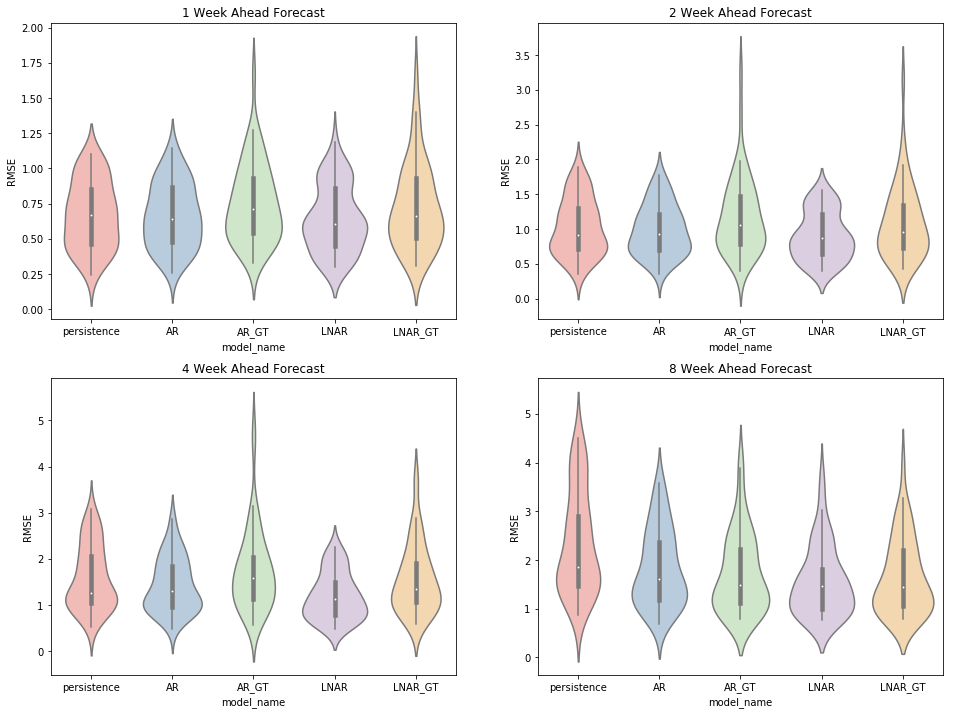

In [31]:
# Visualize model performance
import seaborn as sns
fg, ax = plt.subplots(2,2,figsize=(16,12))

result_dict_df = result_dict_lags[1]
melt_df = pd.melt(result_dict_df, value_vars=result_dict_df.columns, var_name='model_name', value_name='RMSE')
sns.violinplot(x="model_name", y='RMSE',  data=melt_df, palette="Pastel1", ax=ax[0][0])
ax[0][0].set_title("1 Week Ahead Forecast")

result_dict_df = result_dict_lags[2]
melt_df = pd.melt(result_dict_df, value_vars=result_dict_df.columns, var_name='model_name', value_name='RMSE')
sns.violinplot(x="model_name", y='RMSE',  data=melt_df, palette="Pastel1", ax=ax[0][1])
ax[0][1].set_title("2 Week Ahead Forecast")

result_dict_df = result_dict_lags[4]
melt_df = pd.melt(result_dict_df, value_vars=result_dict_df.columns, var_name='model_name', value_name='RMSE')
sns.violinplot(x="model_name", y='RMSE',  data=melt_df, palette="Pastel1", ax=ax[1][0])
ax[1][0].set_title("4 Week Ahead Forecast")

result_dict_df = result_dict_lags[8]
melt_df = pd.melt(result_dict_df, value_vars=result_dict_df.columns, var_name='model_name', value_name='RMSE')
sns.violinplot(x="model_name", y='RMSE',  data=melt_df, palette="Pastel1", ax=ax[1][1])
ax[1][1].set_title("8 Week Ahead Forecast")

# Wilcoxon signed-rank test test

In [34]:
from scipy.stats import wilcoxon
def wilcoxon_test(baseline, model_rmse, fmt=True):
    """ Perform wilcoxon_test with 
        Null: baseline RMSE <= model_rmse
        Alt:  baseline RMSE > model_rmse
    """
    stat, p_val = wilcoxon(baseline, model_rmse, alternative='greater')
    if fmt:
        return f"{stat:.4} ({p_val:.4})"
    return stat, p_val


wilcoxon_test_result = {c:[] for c in [1,2,4,8]}

for target_lag, result_df in result_dict_lags.items():
    baseline = result_df['persistence']
    model_cols = result_df.columns.difference(['persistence'])
    
    stat_p_list = []
    for col in model_cols:
        model_rmse = result_df[col]
        stat_p = wilcoxon_test(baseline, model_rmse)
        stat_p_list.append(stat_p)
    
    wilcoxon_test_result[target_lag] = stat_p_list
pd.DataFrame(wilcoxon_test_result, index=model_cols)

,1,2,4,8
AR,664.0 (0.399),1.021e+03 (0.0001069),1.206e+03 (2.034e-08),1.251e+03 (1.587e-09)
AR_GT,157.0 (1.0),240.0 (0.9999),474.0 (0.9428),1.219e+03 (9.921e-09)
LNAR,941.0 (0.001696),1.164e+03 (1.863e-07),1.215e+03 (1.239e-08),1.249e+03 (1.785e-09)
LNAR_GT,540.0 (0.8267),583.0 (0.7006),730.0 (0.1859),1.224e+03 (7.496e-09)
